Reverse words
=============

Based on translate.py and on code from https://discussions.udacity.com/users/dtrebbien.




In [1]:
%matplotlib inline

"""Binary for training translation models and decoding from them.

See the following papers for more information on neural translation models.
 * http://arxiv.org/abs/1409.3215
 * http://arxiv.org/abs/1409.0473
 * http://arxiv.org/abs/1412.2007
"""

import matplotlib.pyplot as plt


import math
import os
import random
import sys
import time

import numpy as np
import tensorflow as tf

from tensorflow.models.rnn.translate import data_utils
from tensorflow.models.rnn.translate import seq2seq_model


learning_rate = 0.5                  # "Learning rate."
learning_rate_decay_factor = 0.9     # "Learning rate decays by this much."
max_gradient_norm = 5.0              # "Clip gradients to this norm."
num_nodes = 128                      # "Size of each model layer." # was 1024 
num_layers = 1                       # "Number of layers in the model." # was 3

steps_per_eval = 10                  # "How many training steps to do per eval."
evals_per_validate = 10
dodecode = False                     # "Set to True for interactive decoding."


batch_size = 16                      # equals to max number of words per input.
MAX_CHARS_PER_WORD = 10

# We use a number of buckets and pad to the closest one for efficiency.
# See seq2seq_model.Seq2SeqModel for details of how they work.
# _buckets = [(5, 10), (10, 15), (20, 25), (40, 50)]
_buckets = [(MAX_CHARS_PER_WORD, MAX_CHARS_PER_WORD+1)]



In [2]:
import string

vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z]
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - first_letter + 1
    else:
        print('Unexpected character: %s' % char)
        return 0
  
def id2char(dictid):
    if dictid > 0:
        return chr(dictid + first_letter - 1)
    else:
        return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character:  
Unexpected character: ï
1 26 0 0
a z  


In [3]:
def get_batch(size):
    encoder_inputs = [np.random.randint(1, vocabulary_size, size) for _ in range(batch_size)]
    decoder_inputs = [np.zeros(size+1, dtype = np.int32) for _ in range(batch_size)]
    weights = [np.ones(size+1, dtype = np.float32) for _ in range(batch_size)]
    for i in range(batch_size):
        r = random.randint(1, size-1)
        encoder_inputs[i][r:] = 0
        # Reverse the encoder input sequence, but leave a 0 at index 0 and at least one 0 at the end.
        # These are the GO and EOS markers.
        decoder_inputs[i][1:r+1] = encoder_inputs[i][:r][::-1]
        weights[i][r+1:] = 0.0
    return np.transpose(encoder_inputs), np.transpose(decoder_inputs), np.transpose(weights)


Bacthes are three matrices, encoder_inputs and decoder_inputs and weights. Weights are all zeroes.

encoder_inputs have one entry per column (a fake word) with one letter per row.

decoder_inputs (the "labels") are encoder_inputs reversed.

In [4]:
# batch_size=20
b = get_batch(MAX_CHARS_PER_WORD)
print('e_i')
print(b[0])
print('d_i')
print(b[1])



e_i
[[22 25 13  7 17 15 18 16 18 15 19 25 10  8 10 14]
 [ 2  8  7  8  0 19 16 16  9 22 21 24 11 25  3  0]
 [ 0 23 12  5  0 19 23  0  3 21  3  1  8 10 26  0]
 [ 0 22 13 21  0  6  7  0 26  3  0 20  3  0  0  0]
 [ 0 18  0 14  0  0  8  0 20  7  0 11 12  0  0  0]
 [ 0  0  0 22  0  0 15  0 15  4  0 16  0  0  0  0]
 [ 0  0  0 24  0  0  1  0  0  0  0 15  0  0  0  0]
 [ 0  0  0 16  0  0  9  0  0  0  0 17  0  0  0  0]
 [ 0  0  0 23  0  0  7  0  0  0  0 22  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
d_i
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2 18 13 23 17  6  7 16 15  4  3 22 12 10 26 14]
 [22 22 12 16  0 19  9 16 20  7 21 17  3 25  3  0]
 [ 0 23  7 24  0 19  1  0 26  3 19 15  8  8 10  0]
 [ 0  8 13 22  0 15 15  0  3 21  0 16 11  0  0  0]
 [ 0 25  0 14  0  0  8  0  9 22  0 11 10  0  0  0]
 [ 0  0  0 21  0  0  7  0 18 15  0 20  0  0  0  0]
 [ 0  0  0  5  0  0 23  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  8  0  0 16  0  0  0  0 24  0  0  0  0]
 [ 0  0  0  7  0  0 18

In [5]:

def get_validation_batch(text, size):
    words = text.split()[:batch_size]
    encoder_inputs = [np.zeros(size, dtype = np.int32) for _ in range(batch_size)]
    for i, word in enumerate(words):
        l = min(len(word), size - 1)
        for j in range(l):
            encoder_inputs[i][j] = char2id(word[j])
    return np.transpose(encoder_inputs)

def totext(inputs):
    inp = np.transpose(inputs)
    toletters = np.vectorize(id2char)
    return ' '.join([ ''.join(row).rstrip() for row in toletters(inp)]).rstrip()


text_encoded = "the quick brown fox jumps over the lazy dog between you and me but not her"
val_encoder_inputs = get_validation_batch(text_encoded, MAX_CHARS_PER_WORD)
print(val_encoder_inputs)
print("> [%s]" % text_encoded)
print("< [%s]" % totext(val_encoder_inputs))

[[20 17  2  6 10 15 20 12  4  2 25  1 13  2 14  8]
 [ 8 21 18 15 21 22  8  1 15  5 15 14  5 21 15  5]
 [ 5  9 15 24 13  5  5 26  7 20 21  4  0 20 20 18]
 [ 0  3 23  0 16 18  0 25  0 23  0  0  0  0  0  0]
 [ 0 11 14  0 19  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
> [the quick brown fox jumps over the lazy dog between you and me but not her]
< [the quick brown fox jumps over the lazy dog between you and me but not her]


----------------------

Model
-----



In [6]:

def create_model(session, forward_only):
    """Create translation model and initialize or load parameters in session."""
    model = seq2seq_model.Seq2SeqModel(
        vocabulary_size, vocabulary_size, _buckets,
        num_nodes, num_layers, max_gradient_norm, batch_size,
        learning_rate, learning_rate_decay_factor,
        use_lstm = True, forward_only=forward_only)
    
    print("Created model with fresh parameters.")
    session.run(tf.initialize_all_variables())
    return model


In [7]:
# should study this.

def evaluate_model(model, sess, val_encoder_inputs, output_size):
    val_decoder_inputs = np.zeros((output_size+1, batch_size,), dtype = np.int32)
    val_target_weights = np.zeros((output_size+1, batch_size,), dtype = np.float32)
    val_target_weights[0,:] = 1.0
    is_finished = np.full((batch_size,), False, dtype = np.bool_)
    for i in range(output_size):
        _, _, output_logits = model.step(sess,
                                         val_encoder_inputs, val_decoder_inputs, val_target_weights,
                                         bucket_id = 0, forward_only = True)
        p = np.argmax(output_logits[i], axis = 1)
        is_finished = np.logical_or(is_finished, p == 0)
        val_decoder_inputs[i,:] = (1 - is_finished) * p
        val_target_weights[i,:] = (1.0 - is_finished) * 1.0
    return val_decoder_inputs

In [8]:
num_steps = 801


def train():
    step_losses = []
    with tf.Session() as sess:
        # Create model.
        print("Creating %d layers of %d units." % (num_layers, num_nodes))
        model = create_model(sess, False)

        # This is the training loop.
        loss = 0.0
        current_step = 0
        previous_losses = []
        for _ in range(num_steps):

            # Get a batch and make a step.
            encoder_inputs, decoder_inputs, target_weights = get_batch(MAX_CHARS_PER_WORD)
            _, step_loss, _ = model.step(sess,
                                         encoder_inputs, decoder_inputs, target_weights,
                                         0, False)
            step_losses.append(step_loss)
            loss += step_loss / steps_per_eval
            current_step += 1

            # Once in a while, print statistics, and run evals.
            if current_step % steps_per_eval == 0:
                # Print statistics for the previous epoch.
                perplexity = math.exp(loss) if loss < 300 else float('inf')
                print ("step %d learning rate %.4f perplexity %.2f" %
                        (model.global_step.eval(), model.learning_rate.eval(), perplexity))
                
                # Decrease learning rate if no improvement was seen over last 3 times.
                if len(previous_losses) > 2 and loss > max(previous_losses[-3:]):
                    sess.run(model.learning_rate_decay_op)
                previous_losses.append(loss)
                # Zero loss.
                loss = 0.0
                
                # test model.
                if current_step % (steps_per_eval * evals_per_validate) == 0:
                    val_decoder_inputs = evaluate_model(model, sess, val_encoder_inputs, MAX_CHARS_PER_WORD)
                    text_decoded = totext(val_decoder_inputs)
                    print("> [%s]" % text_encoded)
                    print("< [%s]" % text_decoded)
                
                sys.stdout.flush()
    return step_losses


In [9]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

all_losses = train()


Creating 1 layers of 128 units.
Created model with fresh parameters.
step 10 learning rate 0.5000 perplexity 24.11
step 20 learning rate 0.5000 perplexity 20.78
step 30 learning rate 0.5000 perplexity 18.81
step 40 learning rate 0.5000 perplexity 17.93
step 50 learning rate 0.5000 perplexity 15.89
step 60 learning rate 0.5000 perplexity 13.10
step 70 learning rate 0.5000 perplexity 11.91
step 80 learning rate 0.5000 perplexity 11.24
step 90 learning rate 0.5000 perplexity 8.55
step 100 learning rate 0.5000 perplexity 7.89
> [the quick brown fox jumps over the lazy dog between you and me but not her]
< [h ccck ww oo sssss rrr h yaa o eeee oo aa e tt t rr]
step 110 learning rate 0.5000 perplexity 7.15
step 120 learning rate 0.5000 perplexity 6.50
step 130 learning rate 0.5000 perplexity 5.85
step 140 learning rate 0.5000 perplexity 6.50
step 150 learning rate 0.5000 perplexity 5.41
step 160 learning rate 0.5000 perplexity 5.13
step 170 learning rate 0.5000 perplexity 4.91
step 180 learni

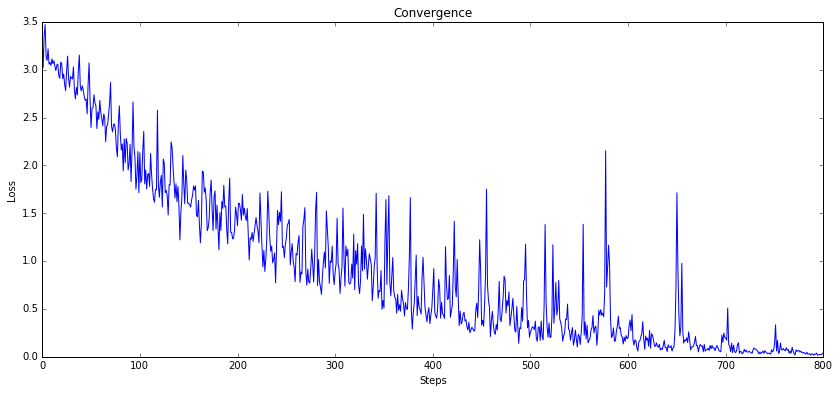

In [10]:
# show chart of losses

plt.figure(num=1,figsize=(14,6))
plt.plot(all_losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Convergence")
plt.show()


In [11]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

def self_test():
    """Test the translation model."""
    
    with tf.Session() as sess:
        print("Self-test for neural translation model.")
        # Create model with vocabularies of 10, 2 small buckets, 2 layers of 32.
        model = seq2seq_model.Seq2SeqModel(10, 10, [(3, 3), (6, 6)], 32, 2,
                                       5.0, 32, 0.3, 0.99, num_samples=8)
        sess.run(tf.initialize_all_variables())

        # Fake data set for both the (3, 3) and (6, 6) bucket.
        data_set = ([([1, 1], [2, 2]), ([3, 3], [4]), ([5], [6])],
                    [([1, 1, 1, 1, 1], [2, 2, 2, 2, 2]), ([3, 3, 3], [5, 6])])
        for _ in range(5):  # Train the fake model for 5 steps.
            bucket_id = random.choice([0, 1])
            encoder_inputs, decoder_inputs, target_weights = model.get_batch(data_set, bucket_id)
            model.step(sess, encoder_inputs, decoder_inputs, target_weights, bucket_id, False)

self_test()

Self-test for neural translation model.
